# EMO task

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dependencies

In [1]:
!pip install transformers -q
!pip install accelerate -U -q
!pip install datasets -q
!pip install torch-summary -q
!pip install graphviz -q
!pip install torchview -q
!pip install bertviz -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
repo_path = "https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/"
branch = "main"

In [3]:
utils_url = f"{repo_path}{branch}/utils.py"
evaluation_url = f"{repo_path}{branch}/evaluation.py"

import os
if os.path.exists("utils.py"):
  !rm "utils.py"
if os.path.exists("evaluation.py"):
  !rm "evaluation.py"

!wget {utils_url}
!wget {evaluation_url}

--2023-07-04 07:57:54--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14142 (14K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  13.81K  --.-KB/s    in 0s      

2023-07-04 07:57:54 (89.5 MB/s) - ‘utils.py’ saved [14142/14142]

--2023-07-04 07:57:54--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/evaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10675 (10K) [text/pl

In [4]:
import json
import torch
from torch import nn
from torch.nn import BCEWithLogitsLoss
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
from transformers import BertPreTrainedModel, BertModel
from transformers import RobertaModel,RobertaPreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput
import importlib
import sys
from utils import *
importlib.reload(sys.modules['utils'])

<module 'utils' from '/content/utils.py'>

In [5]:
# set CUDA if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("======= CUDA Available =======")
else:
    device = torch.device('cpu')
    print("======= CUDA NOT Available, run on CPU =======")
device = torch.device('cpu') # otw goes out of memory

======= CUDA Available =======


## Dataset

Dataset paths

In [6]:
TRAIN_DATA = f"{repo_path}{branch}/datasets/internal_train_essay_level_preproc.tsv"
VAL_DATA = f"{repo_path}{branch}/datasets/internal_val_essay_level_preproc.tsv"
DEV_DATA = f"{repo_path}{branch}/datasets/dev_essay_level_preproc.tsv"

Read dataframes

In [7]:
train_df = pd.read_csv(TRAIN_DATA, sep='\t')
val_df = pd.read_csv(VAL_DATA, sep='\t')
dev_df = pd.read_csv(DEV_DATA, sep='\t')

Optional subsample

In [ ]:
train_df = train_df[:20]
val_df = val_df[:10]
dev_df = dev_df[:10]

Encode targets

In [8]:
label_encoder = EmotionsLabelEncoder()
label_encoder.fit(train_df.emotion)

In [9]:
y_train = label_encoder.encode(train_df.emotion)
y_val = label_encoder.encode(val_df.emotion)
y_dev = label_encoder.encode(dev_df.emotion)

In [30]:
y_train_pre = [ x[:2] for x in y_train]
y_val_pre = [ x[:2] for x in y_val]

In [ ]:
y_train_pre

In [51]:
features_list = ['anger_count', 'disgust_count', 'fear_count', 'joy_count', 'sadness_count', 'surprise_count', 'hope_count']
features_train =  np.array(train_df[features_list])
features_val =  np.array(val_df[features_list])
features_dev =  np.array(dev_df[features_list])

In [ ]:
features_train

## Model

In [12]:
model_type ={
  'distilroberta-emotion':'j-hartmann/emotion-english-distilroberta-base',
  'roberta-emotion':'j-hartmann/emotion-english-roberta-large',
  'bert-base':'bert-base-cased'
}

In [13]:
NUM_LABELS = 8

model_config = {
    'model_id': 'bert_lexicon',
    'tokenizer_name': model_type.get('bert-base'),
    'model_name': model_type.get('bert-base'),
    'train_batch_size': 4,
    'val_batch_size': 4,
    'learning_rate': 5e-5,
    'weight_decay': 0,
    'epochs': 10,
    'seed': 42,
    'patience': 10,
    'early_stopping_threshold': 0
} # TODO: expand...

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_config['tokenizer_name'], truncation=True)

**Baseline model**

In [32]:
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels=2,
    ignore_mismatched_sizes=True)#,
    #problem_type="single_label_classification")
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

**Custom "lexicon" Bert model**

In [56]:
num_features=features_train.shape[1]
class BertLexicon(BertPreTrainedModel):
  def __init__(self, config):
    super().__init__(config)
    self.num_labels = config.num_labels
    self.config = config
    self.n_features = num_features
    self.bert = BertModel(config)
    self.dropout = nn.Dropout(0.3)
    self.classifier = nn.Linear(config.hidden_size+num_features, config.num_labels)
    self.post_init()

  def forward(
    self,
    input_ids=None,
    attention_mask=None,
    token_type_ids=None,
    position_ids=None,
    head_mask=None,
    inputs_embeds=None,
    labels=None,
    output_attentions=None,
    output_hidden_states=None,
    return_dict=None,
    features=None
  ):
    return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    outputs = self.bert(
      input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids,
      position_ids=position_ids,
      head_mask=head_mask,
      inputs_embeds=inputs_embeds,
      output_attentions=output_attentions,
      output_hidden_states=output_hidden_states,
      return_dict=return_dict,
    )

    pooled_output = outputs[1]

    pooled_output = self.dropout(pooled_output)

    if features is not None:
      pooled_output = torch.cat((pooled_output, features), dim=1)
    logits = self.classifier(pooled_output)

    loss = None
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits, labels)
    if not return_dict:
      output = (logits,) + outputs[2:]
      return ((loss,) + output) if loss is not None else output

    return SequenceClassifierOutput(
      loss=loss,
      logits=logits,
      hidden_states=outputs.hidden_states,
      attentions=outputs.attentions,
    )

In [ ]:
model = BertLexicon.from_pretrained(model_type.get('bert-base'),num_labels=NUM_LABELS)
model.to(device)

## Training

Prepare datasets

In [47]:
train_set = EMODataset(tokenizer=tokenizer, essay=train_df.essay, targets=y_train)#, features=features_train)
val_set = EMODataset(tokenizer=tokenizer, essay=val_df.essay, targets=y_val)#, features=features_val)
#dev_set = EMODataset(tokenizer=tokenizer, essay=dev_df.essay, targets=y_dev)#, features=features_dev)

Set up training

In [34]:
train_arguments = TrainingArguments(
    output_dir=f"./{model_config['model_name']}",
    per_device_train_batch_size=model_config['train_batch_size'],
    per_device_eval_batch_size=model_config['val_batch_size'],
    num_train_epochs=2,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps = 150,
    save_steps = 150,
    learning_rate=model_config['learning_rate'],
    weight_decay=model_config['weight_decay'],
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    seed=model_config['seed'],
    logging_strategy = "epoch"
) # TODO: custom other params

In [35]:
trainer = Trainer(
    model=model,
    args=train_arguments,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer,
    compute_metrics=compute_EMO_metrics_trainer
)

Callbacks

In [ ]:
class TrainerLoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero: # whether this process is the main one in a distributed setting
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=model_config['patience'],
    early_stopping_threshold=model_config['early_stopping_threshold']))

trainer.add_callback(TrainerLoggingCallback(model_config['model_id']+"_log.json"))

Start training

In [36]:
trainer.train()

Step,Training Loss,Validation Loss,Sklearn Accuracy,Roc Auc Micro,Accuracy,Micro Precision,Micro Recall,Micro F,Macro Precision,Macro Recall,Macro F
150,No log,0.488605,0.746988,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
300,0.411200,0.363577,0.746988,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344:

TrainOutput(global_step=314, training_loss=0.3984734359060883, metrics={'train_runtime': 150.168, 'train_samples_per_second': 8.337, 'train_steps_per_second': 2.091, 'total_flos': 329415041310720.0, 'train_loss': 0.3984734359060883, 'epoch': 2.0})

In [ ]:
# Access the training logs
train_logs = trainer.state.log_history

# Extract the loss values from the logs
train_loss_values = [log.get('loss') for log in train_logs if log.get('loss') is not None]
eval_loss_values = [log.get('eval_loss') for log in train_logs if log.get('eval_loss') is not None]
eval_epochs = [log.get('epoch') for log in train_logs if log.get('eval_loss') is not None]

In [ ]:
train_logs

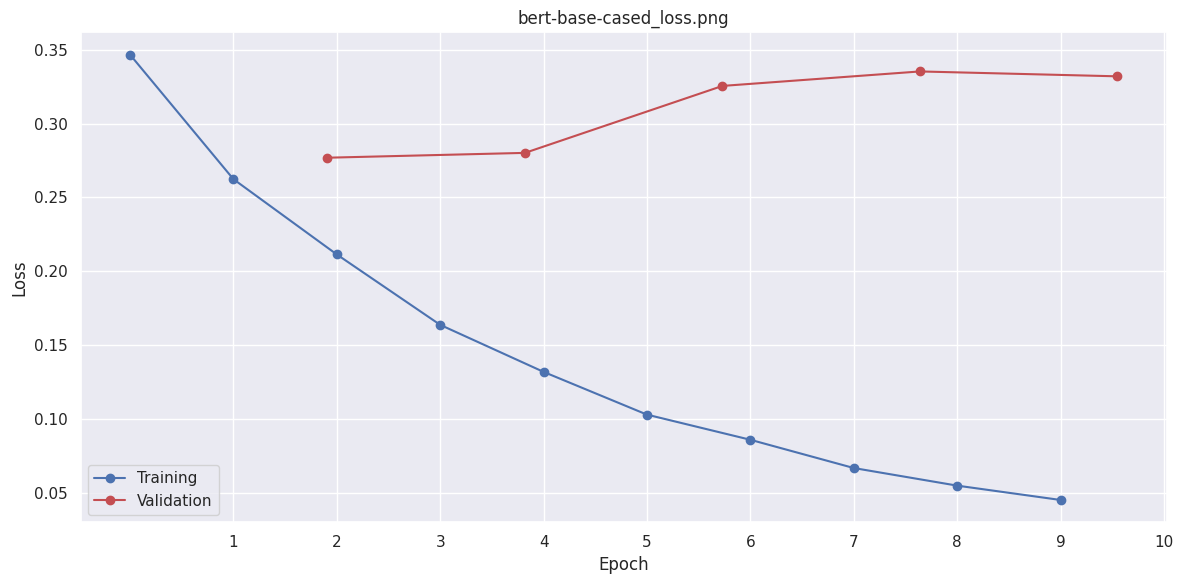

In [ ]:
plot_loss_curve(train_loss_values, eval_loss_values, eval_epochs,"loss", f"{model_config['model_name']}_loss.png")

## Evaluation

In [ ]:
def predict_emotions(results, gold_emotions):

  binarized_predictions = np.where(results.predictions >= 0.5, 1, 0)

  for i, bin_pred in enumerate(binarized_predictions):
    if np.all(bin_pred==0):
      binarized_predictions[i][np.argmax(results.predictions[i])] = 1

  predicted_emotions = label_encoder.decode(binarized_predictions)
  return predicted_emotions


In [37]:
trainer.state.best_model_checkpoint

'./bert-base-cased/checkpoint-300'

In [ ]:
outs = trainer.predict(dev_set)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
gold_emotions = gold_emotions = label_encoder.decode(outs.label_ids)
predicted_emotions = predict_emotions(outs, gold_emotions)

In [ ]:
write_EMO_predictions(predicted_emotions, model_config['model_id']+"_predictions_EMO.tsv")
challenge_metrics = compute_EMO_metrics(golds=gold_emotions, predictions=predicted_emotions)
write_dict_to_json(challenge_metrics, model_config['model_id']+"_dev_metrics.json")
challenge_metrics

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'micro_recall': 0.5732,
 'micro_precision': 0.6779,
 'micro_f': 0.6211,
 'macro_recall': 0.2534,
 'macro_precision': 0.2341,
 'macro_F': 0.2429,
 'accuracy': 0.4505}

In [ ]:
plot_confusion_matrix(golds=gold_emotions, predictions=predicted_emotions, path=model_config['model_id']+"_confusion_matrix.pdf", title=model_config['model_id'])

In [ ]:
plot_model_graph(model=model, input_data=tokenizer("Hello world!", return_tensors="pt"), path=model_config['model_id']+"_graph")

In [ ]:
print_model_summary(model=model, path=model_config['model_id']+"_summary.txt")

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               22,268,928
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Linear: 1-3                            6,152
Total params: 108,316,424
Trainable params: 108,316,424
Non-trainable params: 0


## Save model on Google Drive

In [ ]:
trainer.state.best_model_checkpoint

'./bert-base-cased/checkpoint-1980'

In [ ]:
!mv $trainer.state.best_model_checkpoint /content/drive/MyDrive/hlt

## Inference

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/hlt/best-roberta"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification")

load checkpoint

In [38]:
# Load the checkpoint file
checkpoint_file = "./bert-base-cased/checkpoint-300"

In [57]:
#model = AutoModelForSequenceClassification.from_pretrained(checkpoint_file, num_labels=NUM_LABELS)
model = BertLexicon.from_pretrained(checkpoint_file, num_labels=NUM_LABELS, ignore_mismatched_sizes=True)
trainer = Trainer(model=model)

Some weights of BertLexicon were not initialized from the model checkpoint at ./bert-base-cased/checkpoint-300 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([8, 775]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_set = EMODataset(tokenizer=tokenizer, essay=train_df.essay, targets=y_train, features=features_train)
val_set = EMODataset(tokenizer=tokenizer, essay=val_df.essay, targets=y_val, features=features_val)
dev_set = EMODataset(tokenizer=tokenizer, essay=dev_df.essay, targets=y_dev, features=features_dev)

In [58]:
model

BertLexicon(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [59]:
train_arguments = TrainingArguments(
    output_dir=f"./{model_config['model_name']}",
    per_device_train_batch_size=model_config['train_batch_size'],
    per_device_eval_batch_size=model_config['val_batch_size'],
    num_train_epochs=2,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps = 150,
    save_steps = 150,
    learning_rate=model_config['learning_rate'],
    weight_decay=model_config['weight_decay'],
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    seed=model_config['seed'],
    logging_strategy = "epoch"
) # TODO: custom other params

In [60]:
trainer = Trainer(
    model=model,
    args=train_arguments,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer,
    compute_metrics=compute_EMO_metrics_trainer
)

In [61]:
trainer.train()

Step,Training Loss,Validation Loss,Sklearn Accuracy,Roc Auc Micro,Accuracy,Micro Precision,Micro Recall,Micro F,Macro Precision,Macro Recall,Macro F
150,No log,0.281480,0.403614,0.704170,0.385650,0.796296,0.427861,0.556634,0.294010,0.181859,0.219660
300,0.302300,0.275799,0.475904,0.723009,0.411255,0.760000,0.472637,0.582822,0.285579,0.202181,0.229503


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=314, training_loss=0.2563749787154471, metrics={'train_runtime': 149.769, 'train_samples_per_second': 8.36, 'train_steps_per_second': 2.097, 'total_flos': 329433002803200.0, 'train_loss': 0.2563749787154471, 'epoch': 2.0})

In [ ]:
# Perform prediction using the loaded checkpoint
predictions = trainer.predict(dev_set)

In [ ]:
gold_emotions = label_encoder.decode(predictions.label_ids)
predicted_emotions = predict_emotions(predictions, gold_emotions)

In [ ]:
write_EMO_predictions(predicted_emotions, model_config['model_id']+"_predictions_EMO.tsv")
challenge_metrics = compute_EMO_metrics(golds=gold_emotions, predictions=predicted_emotions)
write_dict_to_json(challenge_metrics, model_config['model_id']+"_dev_metrics.json")
challenge_metrics

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'micro_recall': 0.5935,
 'micro_precision': 0.6791,
 'micro_f': 0.6334,
 'macro_recall': 0.3008,
 'macro_precision': 0.3766,
 'macro_F': 0.3139,
 'accuracy': 0.4635}